<a href="https://colab.research.google.com/github/AbdulRahmanSalaah/genetic-and-antcolony-ai/blob/main/ACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ant Colony Optimization For TSM problem

In [115]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

##Task steps:
###1. **Initializing Parameters:**
  
  1. **Taking Input matrix(d):** distance between cities.
  2. **Initializing hyper-Parameters:**
      * **m:** number of Ant agents.
      * **n:** number of Nodes.
      * **τ<sub>o:** initial phermon rate.
      * **max_itr:** max number of iterations.
      * **ρ:** pheromone evaboration rate.
      * **α:** weight of τ.
      * **β:** wight of η.
      * **Q:** Constant for pheromone deposit.
      * **symmetric:** is the distance from nodes symmetric or not(i.e. d<sub>ij</sub> == d<sub>ji</sub>)
  3. **Initializing most used data:**
      * **η:** heuristic, inverse of distance calculated using this equation:
$$
    η_{ij} = \frac{1}{d_{ij}}
$$
      * **τ:** (n, n) 2d array of pheromone for every path ij  
      * **l:** (m,) 1d array of path length for every ant agent
      * **sol:** (m, n) 2d array of solution path for every ant agent
      * **visited:** m,n 2d array of bool values for every ant deos it visited this or not


###2. **Initializing the important functions:**
  1. **calc_p(self, i, k):**
    * takes ant's number(k) and currunt node(i)
    * claculates <span>$p_{ij}^{k}$</span> for every node j from current node using this equation:
$$
    p_{ij}^k = \frac{[\tau_{ij}]^α \cdot [\eta_{ij}]^β}{\sum_{l \in \mathcal{N}_i^k} [\tau_{il}]^\alpha \cdot [\eta_{il}]^\beta}
$$
    * ruturns a 1d np array with n (<span>$p_{ij}$</span>) for Ant k
  2. **choose_next_node(self, i, k):**
    * takes ant's number(k) and currunt node(i).
    * chooses the next node randomly from unvisited nodes considering the node's probability.
    * if all unvisited node's probabilities = 0 it chooses any one of them randomly with same probability of choice for every node.
    * returns the number of next node
  3. **delta_tau(self,k):**
    * takes ant's number(k).
    * claculates Δτ using this equation:
$$
    {Δτ^k} = \frac{Q}{L_k}
$$
    * returns Δτ
  4. **phermone_update(self):**
    * Update Phermone's level automaticly using this equation
$$
    τ_{ij} = (1-ρ) \cdot τ_{ij} + ∑_{k}^{m} Δτ_{ij}^{k}
$$


  5. **solve(self):**
    1. initializes starting node for each Ant
    2. loops max_itr number of itrations, for every itr:
      1. each Ant moves from starting node to nth node, for every move:
          * mark currunt node as visited.
          * choose the next node
          * save it in sol matrix
      2. after ant reaches the goal, mark last node as visited.
      3. calculate the length of Ant's path and save it in l vector.
      4. updates the phermone level.

###3. requirments

1. try it on diffrant number of nodes (10, 20)
2. for each n: try it on diffrant values of m (1, 5, 10, 20)


In [116]:
m = 1
n = 10
init_tau = 0.1
max_itr = 50
rho = 0.2
alpha = 1
beta = 1
q = 1

In [117]:
import numpy as np

def init_input(n, min_dist=3, max_dist=50, random_state=42, dtype=np.int32):

    np.random.seed(random_state)
    random_values = np.random.randint(low=min_dist, high=max_dist + 1, size=(n, n))
    symmetric_matrix = (random_values + random_values.T) // 2
    np.fill_diagonal(symmetric_matrix, 0)

    return symmetric_matrix.astype(dtype)


In [118]:
class ACO:
  def __init__(self, m, n, init_tau, max_itr, rho, alpha, beta, q, d, symmetric=True):
      self.m = m
      self.n = n
      self.init_tau = init_tau
      self.max_itr = max_itr
      self.rho = rho
      self.alpha = alpha
      self.beta = beta
      self.Q = q
      self.d = d
      self.symmetric = symmetric
      self.eta = np.where(self.d == 0, 0, 1 / (self.d))
      self.tau = np.full((n, n), init_tau, dtype=np.float64)
      self.l = np.zeros((m,), dtype=np.float64)
      self.sol = np.zeros((m, n), dtype=np.int64)
      self.visited = np.zeros((m, n), dtype=np.int64)
      self.best_path = None
      self.best_length = np.inf

  def calc_p(self, i, k):
      p = np.zeros((self.n,))
      p = np.power(self.tau[i], self.alpha) * np.power(self.eta[i], self.beta)
      p[self.visited[k] == 1] = 0

      total = np.sum(p)
      if total > 0:
          p /= total
      else:
        p = np.where(self.visited[k] == 0, 1, 0)
        p /= np.sum(p)
      return p

  def choose_next_node(self, i, k):
      p = self.calc_p(i, k)
      next_node = np.random.choice(self.n, p=p)
      return next_node

  def delta_tau(self,k):
      return self.Q/self.l[k]

  def phermone_update(self):
      self.tau *= (1 - self.rho)

      for k in range(self.m):
          delta_tau_k = self.delta_tau(k)
          for a in range(self.n):
              i = self.sol[k, a]
              j = self.sol[k, (a + 1) % self.n]
              self.tau[i, j] += delta_tau_k
              if self.symmetric:
                  self.tau[j, i] += delta_tau_k

  def solve(self):
      start_nodes = np.random.randint(0, self.n, size=self.m)
      for itr in range(self.max_itr):
          self.sol = np.zeros((self.m, self.n), dtype=np.int64)
          self.visited = np.zeros((self.m, self.n), dtype=np.int64)
          self.sol[:,0] = start_nodes

          for k in range(self.m):
              for a in range(1, self.n):

                  i = self.sol[k, a - 1]
                  self.visited[k, i] = 1
                  next_node = self.choose_next_node(i, k)
                  self.sol[k, a] = next_node
              i = self.sol[k, self.n - 1]
              self.visited[k, i] = 1
              self.l[k] = np.sum(self.d[self.sol[k], np.roll(self.sol[k],-1)])
              if self.l[k] < self.best_length:
                  self.best_length = self.l[k]
                  self.best_path = self.sol[k].copy()
          self.phermone_update()
      return self.best_path, self.best_length


In [119]:
ms = [1, 5, 10, 20, 30]
ns = [10, 20]
init_tau = 0.1
rho = 0.2
max_itr = 50
alpha = 1
beta = 1
Q = 1
best_paths = [[],[]]
best_lengths = [[],[]]

In [120]:
i = 0
for n in ns:
  d = init_input(n, 3, 50)
  for m in ms:
    aco = ACO(m, n, init_tau, max_itr, rho, alpha, beta, Q, d)
    best_path, best_length = aco.solve()
    best_paths[i].append(best_path)
    best_lengths[i].append(best_length)
    print(f"n: {n}, m: {m}, best_length: {best_length}")
    print(f"best path: {best_path}\n")
  i += 1

<ipython-input-118-6fe8681ffb47>:13: RuntimeWarning: divide by zero encountered in divide
  self.eta = np.where(self.d == 0, 0, 1 / (self.d))


n: 10, m: 1, best_length: 184.0
best path: [7 1 0 9 5 4 8 2 6 3]

n: 10, m: 5, best_length: 156.0
best path: [0 4 9 7 1 6 3 8 2 5]

n: 10, m: 10, best_length: 156.0
best path: [5 0 4 9 7 1 6 3 8 2]

n: 10, m: 20, best_length: 156.0
best path: [3 6 1 7 9 4 0 5 2 8]

n: 10, m: 30, best_length: 156.0
best path: [6 3 8 2 5 0 4 9 7 1]

n: 20, m: 1, best_length: 322.0
best path: [13 15  0 17 12 16 11 19 18  7 14  4  1  5  3  2  6 10  9  8]

n: 20, m: 5, best_length: 280.0
best path: [ 5  9  8  1  2  3 19 18  7 11 16 10  6 14  4 12 13 15  0 17]

n: 20, m: 10, best_length: 268.0
best path: [ 2  3  5  9  8 10  6 15 13 12  4 19 18  1 16 11  7 14  0 17]

n: 20, m: 20, best_length: 261.0
best path: [14  5  3  2 18 19 17  0 15 13 12  4  7 11 16  1  9  8 10  6]

n: 20, m: 30, best_length: 253.0
best path: [17  0 15 13 12  4 14  7 11 19 18  1 16 10  6  8  9  5  3  2]



In [121]:
best_lengths

[[np.float64(184.0),
  np.float64(156.0),
  np.float64(156.0),
  np.float64(156.0),
  np.float64(156.0)],
 [np.float64(322.0),
  np.float64(280.0),
  np.float64(268.0),
  np.float64(261.0),
  np.float64(253.0)]]

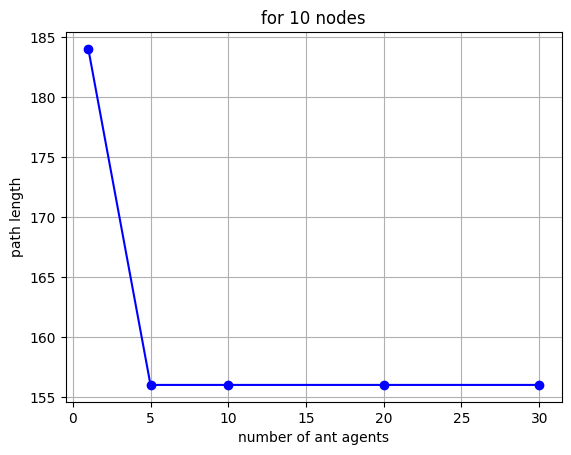

In [122]:

plt.plot(ms, best_lengths[0], marker='o', linestyle='-', color='b')
plt.xlabel('number of ant agents')
plt.ylabel('path length')
plt.title('for 10 nodes')
plt.grid(True)
plt.show()

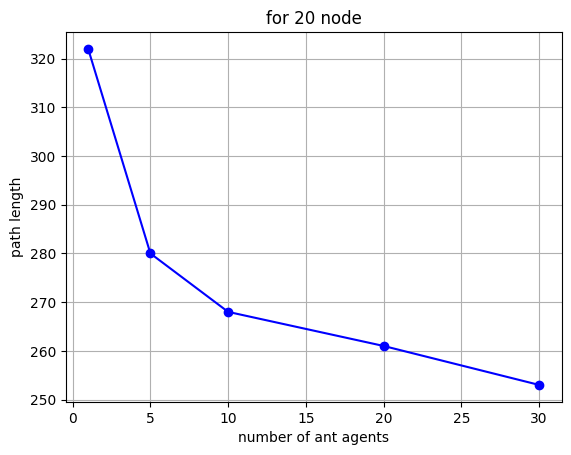

In [123]:
plt.plot(ms, best_lengths[1], marker='o', linestyle='-', color='b')
plt.xlabel('number of ant agents')
plt.ylabel('path length')
plt.title('for 20 node')
plt.grid(True)
plt.show()